In [5]:
## Import packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import copy

In [6]:
## Set parameters

# utility functions are a * x^0.5 + b
a_vect = [1,1]
b_vect = [0,0]

N = len(a_vect) # number of tasks

constr_A = np.array([[1,0],
                     [0,1]])

K = np.shape(constr_A)[0] # number of resources

C = np.array([2,2])

type_obj = 0 # 0 is sqrt root, 1 is log

stop_iter = 10000
delta_x = 0.01
delta_l = 0.01

x_init = np.zeros((N,))
lambda_init = np.zeros((K,))

In [7]:
## Functions of objective and constraint

def sqrt_func(a, b, x):
    return a * x**0.5 + b

def der_sqrt_func(a, x):
    if x == 0:
        return 0.5 * a / (0.0001**0.5)
    return 0.5 * a / (x**0.5)

def log_func(a, b, x):
    return log(np.dot(a, x) + 1) + b

def der_log_func(a, x):
    return a / (np.dot(a, x) + 1) + b
    
def lin_constr(A, C, x):
    return C- np.matmul(A,x)

local_objs = []
for a,b in zip(a_vect, b_vect):
    if type_obj == 0:
        local_objs.append(lambda x, a=a, b=b: sqrt_func(a,b,x))
    else:
        local_objs.append(lambda x, a=a, b=b: log_func(a,b,x))
        
local_ders = []
for a,b in zip(a_vect, b_vect):
    if type_obj == 0:
        local_ders.append(lambda x, a=a: der_sqrt_func(a,x))
    else:
        local_ders.append(lambda x, a=a: der_log_func(a,x))
    
def obj_func(x):
    s = 0
    for (x_i, f) in zip(x, local_objs):
        s += f(x_i)
    return s

def obj_func_der(x):
    out = np.zeros((N,))
    for i in range(N):
        out[i] = local_ders[i](x[i])
    return out
    
constr = (lambda x, A=constr_A, C=C: lin_constr(A, C, x))

In [45]:
x = x_init
lamb = lambda_init

x_history = []
l_history = []
obj_history = []
constr_history = []

for it in range(stop_iter):
    x_der = np.array([local_der_i(x_i) for x_i, local_der_i in zip(x,local_ders)])
    x += delta_x * (x_der - np.matmul(np.transpose(lamb), constr_A))
    x = np.maximum(np.zeros((N,)), x)
    lamb -= delta_l * (constr(x))
    lamb = np.maximum(np.zeros((K,)), lamb)
    
     # save step to memory
    x_history.append(copy.deepcopy(x))
    l_history.append(copy.deepcopy(lamb))
    obj_history.append(obj_func(x))
    constr_history.append(constr(x))

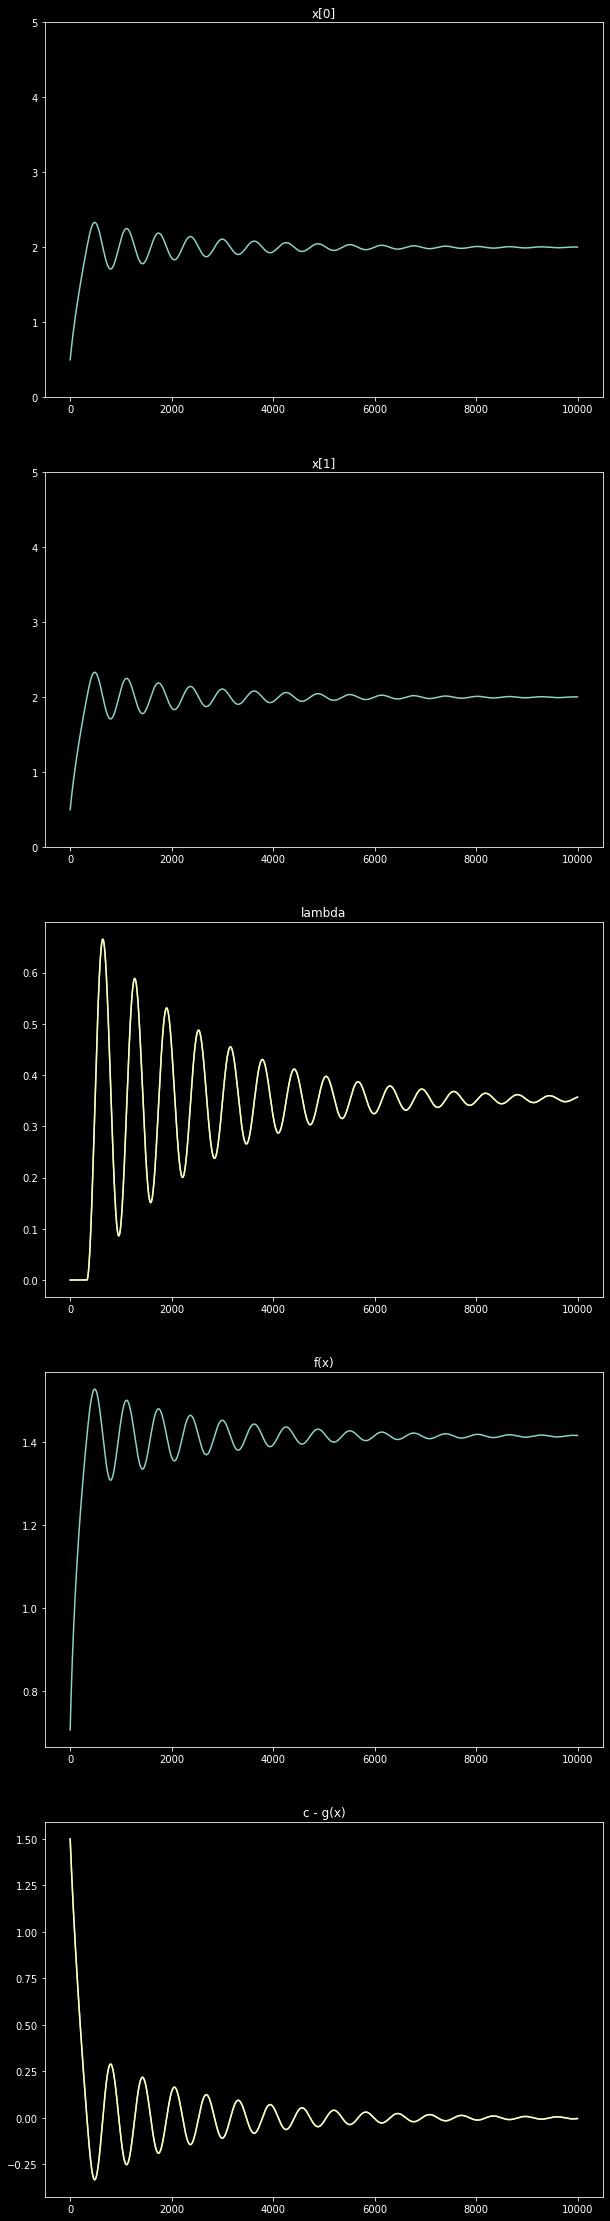

In [46]:
fig, axs = plt.subplots(N+3, 1)
for i in range(N):
    axs[i].plot([el[i] for el in x_history])
    axs[i].set_title('x[{}]'.format(i))
    axs[i].set_ylim([0,5])
axs[N].plot(l_history)
axs[N].set_title('lambda')
axs[N+1].plot(obj_history)
axs[N+1].set_title('f(x)')
axs[N+2].plot(constr_history)
axs[N+2].set_title('c - g(x)')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

## Hide x labels and tick labels for top plots and y ticks for right plots.
    ##for ax in axs.flat:
    ##    ax.label_outer()
fig.set_figwidth(10)
fig.set_figheight(40)
plt.show()

CENTRALIZED RL

STATE is just the number of currently processed tasks. No need to include incoming tasks as we assume we can add as many as we want
ACTION is new number of processed tasks (we limit this to 100)
REWARD is advanced by one (depends on next state basically)

In [47]:
# calculate max possible x for each task
tmp_constr_A = copy.deepcopy(constr_A).astype(float)
tmp_constr_A[tmp_constr_A == 0] = 0.00001  # avoid divide by 0
max_x = np.amin(C/tmp_constr_A, axis=0).astype(int)

# make Q_table with correct dimensions
Q = np.zeros(np.concatenate((max_x+1,max_x+1,2*max_x+1))) # corresponding to local x, local m and local action 
# the 2m + 1 is because the action can also be negative (remove tasks)
# the + 1 is because 0 is also a possibility

# convert from action index to accepted-removed tasks
def a2_xchange(a):
    return a - max_x

# return new state (new number of processed tasks is deterministic while number of incoming tasks is sampled from a uniform distribution)
def state_trans(s,a):
    new_x = s[:N] + a2_xchange(a)
    new_m = np.random.uniform(np.zeros(np.shape(new_x)), max_x+1, np.shape(new_x))
    new_m = new_m.astype(int)
    return np.concatenate((new_x, new_m))

def reward(s,a):
    x = s[:N]
    x_change = a2_xchange(a)
    x_new = x + x_change
    r = 0
    for f,x_i_new in zip(local_objs, x_new):
        r += f(x_i_new)
    return r

def indexer(arr, indexes):
    out = arr
    for i in indexes:
        out = out[i]
    return out

def doable_actions(s, Q):
    out_values = []
    out_indexes = []
    x = s[:N]
    m = s[N:2*N]
    for index, value in np.ndenumerate(indexer(Q,s)):
        x_change = a2_xchange(index)
        new_x = x + x_change
        cap_constraint = (C >= np.matmul(constr_A, new_x)).all()
        positive_x = (new_x >= np.zeros(np.shape(new_x))).all()
        arrival_constraint = (m >= x_change).all()
        if cap_constraint and positive_x and arrival_constraint:
            out_values.append(value)
            out_indexes.append(index)
    return out_values, out_indexes
    
    
gamma = 0.99
epsilon_decay = 0.99
alpha = 0.01
n_episodes = 100000
episode_length = 1000
Rs = []

for episode in range(n_episodes):
    tmp = np.shape(x)
    state = np.concatenate((np.random.uniform(np.zeros(tmp), max_x+1, tmp), np.random.uniform(np.zeros(tmp), max_x+1, tmp)))
    state = state.astype(int)
    rs = [] 
    epsilon = 1
    if episode % 10 == 0:
        print(episode)
    for it in range(episode_length):
        out_values, out_indexes = doable_actions(state,Q)
        if np.random.uniform(0,1) > epsilon:
            tmp_ind = np.argmax(out_values)
            a = out_indexes[tmp_ind]
        else:
            random_int = int(np.random.uniform(0, len(out_indexes)))
            a = out_indexes[random_int]
        r = reward(state,a)
        rs.append(r)
        new_state = state_trans(state,a)
        Q = np.expand_dims(Q, len(np.shape(Q)))
        Q_s_a = indexer(Q, np.concatenate((state, a)))
        Q_s_a[0] = (1-alpha)*Q_s_a + alpha * (r + gamma * np.max(Q[new_state]))
        Q = np.squeeze(Q, len(np.shape(Q))-1)
        state = new_state
        epsilon *= epsilon_decay
    Rs.append(rs)



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [48]:
np.shape(Q)

(3, 3, 3, 3, 5, 5)

In [49]:
Q

array([[[[[[  0.        ,   0.        ,   0.        ,   0.        ,
              0.        ],
           [  0.        ,   0.        ,   0.        ,   0.        ,
              0.        ],
           [  0.        ,   0.        , 140.00714267,   0.        ,
              0.        ],
           [  0.        ,   0.        ,   0.        ,   0.        ,
              0.        ],
           [  0.        ,   0.        ,   0.        ,   0.        ,
              0.        ]],

          [[  0.        ,   0.        ,   0.        ,   0.        ,
              0.        ],
           [  0.        ,   0.        ,   0.        ,   0.        ,
              0.        ],
           [  0.        ,   0.        , 140.00714267, 140.00714267,
              0.        ],
           [  0.        ,   0.        ,   0.        ,   0.        ,
              0.        ],
           [  0.        ,   0.        ,   0.        ,   0.        ,
              0.        ]],

          [[  0.        ,   0.        ,   0.  

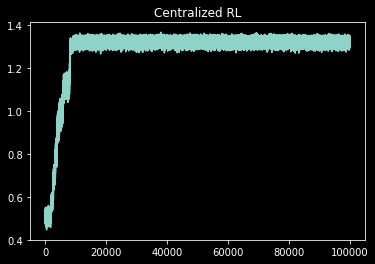

In [50]:
tot_rews = [sum(rs)/len(rs) for rs in Rs]
plt.plot(tot_rews)
plt.title('Centralized RL')
plt.show()

## CENTRALIZED RL BUT USING LAMBDA

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from collections import deque

In [ ]:
class Actor:
    def __init__(self):
        self.NN = self._init_NN()

    def _init_NN(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(16, input_shape=(N+K,), activation="relu", name="layer1"))
        model.add(layers.Dense(16, activation="relu", name="layer2"))
        model.add(layers.Dense(N, activation="sigmoid", name="layer3"))
        return model

    def _pred1(self, NN, inp):
        return NN(np.expand_dims(inp, axis = 0))[0]

    def get_action(self, s):
        return self._pred1(self.NN, s).numpy()

    def update(self, state_list, w):
        delta_np = []
        for s in state_list:
            with tf.GradientTape() as tape:
                mu = self._pred1(self.NN, s)
                delta = tape.gradient(mu, self.NN.trainable_weights)
                if delta_np == []:
                    delta_np = [el.numpy() for el in delta]
                else:
                    delta_np = [el1+el2.numpy() for el1,el2 in zip(delta_np,delta)]

        dot_prod = 0
        for el1,el2 in zip(delta_np,w):
            dot_prod += np.sum(el1*el2)

        updates = [el * dot_prod * alpha_theta for el in delta_np]

        #apply optimisation step
        current_weights = self.NN.get_weights()
        updated_weights = [current_tensor + update for (update, current_tensor) in zip(updates, current_weights)]
        self.NN.set_weights(updated_weights)


class Critic:
    def __init__(self):
        self.w = 0
        self.v = np.zeros((loc_state_size,))

    def _pred1(self, NN, inp):
        return NN(np.expand_dims(inp, axis = 0))[0]

    def grad(self, s, actorNN):
        with tf.GradientTape() as tape:
            mu = self._pred1(actorNN, s)
            delta = tape.gradient(mu, actorNN.trainable_weights)
            delta_np = [el.numpy() for el in delta]
        return delta_np

    def V(self, s):
        return np.dot(self.v, s)

    def advantage(self, s, a, actorNN):
        delta_np = self.grad(s, actorNN)
        if type(self.w) != list:
            self.w = [np.zeros(np.shape(el)) for el in delta_np]
        dot_prod = 0
        for el1,el2 in zip(delta_np,self.w):
            dot_prod += np.sum(el1*el2)
        return (a-self._pred1(actorNN, s)) * dot_prod

    def Q_sa(self,s,a,actorNN):
        return self.advantage(s,a,actorNN) + self.V(s)

    def update(self, s_lst, a_lst, delta_lst, actorNN):
        updates = []
        for s,a,delta in zip(s_lst, a_lst, delta_lst):
            delta_np = self.grad(s, actorNN)
            tmp = a - self._pred1(actorNN, s)
            if updates == []:
                updates = [alpha_w * delta * tmp * el for el in delta_np]
            else:
                updates = [alpha_w*delta*tmp*el + update for el,update in zip(delta_np,updates)]

        #apply optimisation step
        current_weights = self.w
        self.w = [current_tensor + update for (update, current_tensor) in zip(updates, current_weights)]

        for s,delta in zip(s_lst, delta_lst):
            self.v += alpha_v * delta * s

In [ ]:
# calculate max possible x for each task
tmp_constr_A = copy.deepcopy(constr_A).astype(float)
tmp_constr_A[tmp_constr_A == 0] = 0.00001 # avoid divide by 0
max_x = np.amin(C/tmp_constr_A, axis=0).astype(int)

a_std = 0.01 # not sure what this should be
alpha_theta = 0.001
alpha_w = 0.001
alpha_v = 0.001

# create list of actors and critics 
actor = Actor()
critic = Critic()

def g_tplus1(x_new):
    return C - np.matmul(constr_A, x_new)

# return new state (new number of processed tasks is deterministic while number of incoming tasks is sampled from a uniform distribution)
def state_trans(s,a):
    # features of state
    x_plus_m = s[:N]
    lambdas = s[N:]

    # get x(t+1) + m(t+1)
    x_new_float = x_plus_m * a
    x_new = np.zeros((N,))
    decimals = x_new_float - np.floor(x_new_float)
    for i, (x, randomVar, dec) in enumerate(zip(x_new_float, np.random.uniform(np.zeros(N,), np.ones(N,), (N,)), decimals)):
        if randomVar < dec:
            x_new[i] = np.floor(x) + 1
        else:
            x_new[i] = np.floor(x)

    m_new = np.random.uniform(np.zeros((N,)), max_x+1, (N,)).astype(int)

    # get lambda(t+1)
    lambdas_new = np.maximum(np.ones((N,)), lambdas - delta_l * g_tplus1(x_new))

    return np.concatenate((x_new + m_new, lambdas_new)), x_new

def reward_i(global_state, x_i, i):
    lambdas = global_state[N:]
    dUidxi = local_ders[i](x_i)
    lambdas_ais_prod = np.dot(lambdas, constr_A[:][i])
    return - abs(dUidxi - lambdas_ais_prod)

#def global2i_state(state, i):
#    xplusm_i = np.array([state[i]])
#    lambdas = state[N:]
#    return np.concatenate((xplusm_i, lambdas))

#def locals2global_state(local_states):
#    xplusm = [el[0] for el in local_states]
#    lamb = local_states[0][1:]
#    return np.concatenate(xplusm,lamb)

def indexer(arr, indexes):
    out = arr
    for i in indexes:
        out = out[i]
    return out
    
    
gamma = 0.99
n_episodes = 100000
episode_length = 1000
Rs = []
replay_mem = [deque(maxlen = 50000) for _ in range(N)]

update_every = 50
batch_size = 100

for episode in range(n_episodes):
    state = np.concatenate((np.random.uniform(np.zeros((N,)), 2*max_x+2, (N,)), np.zeros((K,))))
    state = state.astype(int)
    rs = [] 
    if episode % 10 == 0:
        print(episode)
    for it in range(episode_length):
        # interaction with environment
        a = actor.get_action(state)
        noisy_a = np.random.normal(loc=a, scale = a_std)
        new_state, xs = state_trans(state,noisy_a)
        r = [reward_i(new_state, x, i) for i,x in enumerate(xs)]
        r = sum(r)
        rs.append(r)
        replay_mem.append((state, noisy_a, r, new_state))
        state = new_state

        # update actors and critics
        if it % 50 == 0 and len(replay_mem[0]) >= batch_size:
            batch = random.sample(replay_mem[i], batch_size)
            delta_list = []
            state_list = []
            action_list = []
            for el in batch:
                s = el[0]
                state_list.append(s)
                a = el[1]
                action_list.append(a)
                r = el[2]
                s_new = el[3]
                mu_s_new = actor.get_action(s_new)
                q_next = critic.Q_sa(s_new, mu_s_new, actor.NN)
                q_sa = critic.Q_sa(s, a, actor.NN)
                delta_list.append(r + gamma * q_next - q_sa)
            actor.update(state_list, critic.w)
            critic.update(state_list, action_list, delta_list, actor.NN)

    Rs.append(rs)


## DISTRIBUTED RL

local state = {x_i + m_i, lambdas}  
local action = p_i  
state transition is stochastic because the action is a probability (so maybe don't need NOISE? we probably still do for better exploration)  
local reward = - |dU_i(x_i(t+1))/dx_i(t+1) - sum(lambda_k(t+1) + a_ik)|, maybe should do ^n, where n is smaller than 1 in order to reward sharper changes  
max arrivals are limited to the max capacity of that task for the most restrictive resource, as in the centralised  
initial state always has 0s as lambdas (maybe this is wrong)  

In [50]:
%reset

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from collections import deque

In [9]:
import time

In [10]:
class cstmLoss(keras.losses.Loss):
  def __init__(self, weigths):
    super().__init__()  
    self.weights = weigths

  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    weights = tf.convert_to_tensor(self.weights)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(y_true - weights * y_pred, axis=-1)

In [13]:
loc_state_size = K + 1

class Actor:
    def __init__(self):
        self.NN = self._init_NN()
        self.target_NN = self._init_targetNN()

    def _init_NN(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(16, input_shape=(loc_state_size,), activation="relu", name="layer1"))
        model.add(layers.Dense(16, activation="relu", name="layer2"))
        model.add(layers.Dense(1, activation="sigmoid", name="layer3"))

        model.compile(optimizer=keras.optimizers.SGD(learning_rate=alpha_theta), loss=tf.keras.losses.MeanSquaredError())
        return model

    def _init_targetNN(self):
        model = self._init_NN()
        weights = self.NN.get_weights()
        model.set_weights(weights)
        return model

    def _pred1(self, NN, inp):
        return NN(np.expand_dims(inp, axis = 0))[0]

    def get_action(self, s):
        return self._pred1(self.NN, s).numpy()[0]

    def get_action_arr(self, states):
        return np.squeeze(np.array(self.NN(states)), axis=1)

    def update(self, state_arr, action_arr, criticNN):
        with tf.GradientTape() as tape:
            inputs = tf.convert_to_tensor(np.concatenate((state_arr, np.expand_dims(action_arr, axis=1)), axis=1))
            Qs = criticNN(inputs)
            wrt_vars = tf.expand_dims(inputs[:,-1], axis=1)
        batch_jac = tape.batch_jacobian(Qs, wrt_vars).numpy()
        self.NN.compile(optimizer=keras.optimizers.SGD(learning_rate=alpha_theta), loss=cstmLoss(np.squeeze(batch_jac, axis=2)))
        self.NN.train_on_batch(state_arr, np.zeros(np.shape(state_arr)[0],))


class Critic:
    def __init__(self):
        self.NN = self._init_NN()
        self.target_NN = self._init_targetNN()

    def _init_NN(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(16, input_shape=(loc_state_size+1,), activation="relu", name="layer1"))
        model.add(layers.Dense(16, activation="relu", name="layer2"))
        model.add(layers.Dense(1, activation="sigmoid", name="layer3"))

        model.compile(optimizer=keras.optimizers.SGD(learning_rate=alpha_thetaCritic), loss=tf.keras.losses.MeanSquaredError())
        return model

    def _init_targetNN(self):
        model = self._init_NN()
        weights = self.NN.get_weights()
        model.set_weights(weights)
        return model

    def _pred1(self, NN, inp):
        return NN(np.expand_dims(inp, axis = 0))[0]

    def Q_sa_trgt(self,states,actorNN):
        actions = actorNN(states).numpy()
        inputs = np.concatenate((states,actions), axis=1)
        return self.target_NN(inputs).numpy()

    def update(self, s_arr, a_arr, y_arr):
        inputs = np.concatenate((s_arr,np.expand_dims(a_arr, axis=1)), axis=1)
        self.NN.train_on_batch(inputs, y_arr)
        

In [14]:
# calculate max possible x for each task
tmp_constr_A = copy.deepcopy(constr_A).astype(float)
tmp_constr_A[tmp_constr_A == 0] = 0.00001  # avoid divide by 0
max_x = np.amin(C/tmp_constr_A, axis=0).astype(int)


a_std = 0.01 # not sure what this should be
alpha_theta = 0.001
alpha_thetaCritic = 0.001

# create list of actors and critics 
actors = [Actor() for _ in range(N)]
critics = [Critic() for _ in range(N)]

def g_tplus1(x_new):
    return C - np.matmul(constr_A, x_new)

# return new state (new number of processed tasks is deterministic while number of incoming tasks is sampled from a uniform distribution)
def state_trans(s,a):
    # features of state
    x_plus_m = s[:N]
    lambdas = s[N:]

    # get x(t+1) + m(t+1)
    x_new_float = x_plus_m * a
    x_new = np.zeros((N,))
    decimals = x_new_float - np.floor(x_new_float)
    for i, (x, randomVar, dec) in enumerate(zip(x_new_float, np.random.uniform(np.zeros(N,), np.ones(N,), (N,)), decimals)):
        if randomVar < dec:
            x_new[i] = np.floor(x) + 1
        else:
            x_new[i] = np.floor(x)

    m_new = np.random.uniform(np.zeros((N,)), max_x+1, (N,)).astype(int)

    # get lambda(t+1)
    lambdas_new = np.maximum(np.ones((N,)), lambdas - delta_l * g_tplus1(x_new))

    return np.concatenate((x_new + m_new, lambdas_new)), x_new

def reward_i(global_state, x_i, i):
    lambdas = global_state[N:]
    dUidxi = local_ders[i](x_i)
    lambdas_ais_prod = np.dot(lambdas, constr_A[:][i])
    return - abs(dUidxi - lambdas_ais_prod)

def global2i_state(state, i):
    xplusm_i = np.array([state[i]])
    lambdas = state[N:]
    return np.concatenate((xplusm_i, lambdas))

def locals2global_state(local_states):
    xplusm = [el[0] for el in local_states]
    lamb = local_states[0][1:]
    return np.concatenate(xplusm,lamb)

def indexer(arr, indexes):
    out = arr
    for i in indexes:
        out = out[i]
    return out
    
    
gamma = 0.99
n_episodes = 100000
episode_length = 1000
Rs = []
replay_mem = [deque(maxlen = 50000) for _ in range(N)]

update_every = 50
batch_size = 100

for episode in range(n_episodes):
    state = np.concatenate((np.random.uniform(np.zeros((N,)), 2*max_x+2, (N,)), np.zeros((K,))))
    state = state.astype(int)
    rs = [] 

    if episode % 10 == 0:
        print(episode)

    for it in range(episode_length):
        # interaction with environment
        local_states = [global2i_state(state, i) for i in range(N)]
        local_actions = [actors[i].get_action(s_i) for i,s_i in enumerate(local_states)]
        noisy_actions = np.random.normal(loc=local_actions, scale = a_std)
        new_state, xs = state_trans(state,noisy_actions)
        r = [reward_i(new_state, x, i) for i,x in enumerate(xs)]
        rs.append(r)
        new_local_states = [global2i_state(new_state, i) for i in range(N)]
        for i in range(N):
            replay_mem[i].append(np.concatenate([local_states[i], [noisy_actions[i]], [r[i]], new_local_states[i]]))
        state = new_state

        # update actors and critics
        if it % 50 == 0 and len(replay_mem[0]) >= batch_size: 
            for i in range(N):
                # extract <S,A,R,S'> samples
                batch = np.array(random.sample(replay_mem[i], batch_size))
                state_arr = batch[:,:1+K]
                action_arr = batch[:,1+K]
                reward_arr = batch[:,2+K]
                state_new_arr = batch[:,3+K:]

                # calculate Q values
                q_next_arr = critics[i].Q_sa_trgt(state_new_arr, actors[i].target_NN) 

                # calculate delta values
                y_arr = reward_arr + gamma * q_next_arr

                # update actor and critic parameters
                critics[i].update(state_arr, action_arr, y_arr)
                actors[i].update(state_arr, action_arr, critics[i].NN)

                # update target networks
                critic_weights = critics[i].NN.get_weights()
                target_critic_weights = critics[i].target_NN.get_weights()
                new_weights = [0.1*el1+0.9*el2 for el1,el2 in zip(critic_weights, target_critic_weights)]
                critics[i].target_NN.set_weights(new_weights)

                actor_weights = actors[i].NN.get_weights()
                target_actor_weights = actors[i].target_NN.get_weights()
                new_weights = [0.1*el1+0.9*el2 for el1,el2 in zip(actor_weights, target_actor_weights)]
                actors[i].target_NN.set_weights(new_weights)

    Rs.append(rs)


0
10
20
30
40
50
60
70
80
90
100
110
120


<class 'list'>


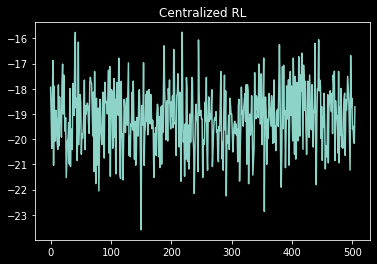

In [115]:
CHECK HOW TO PLOT REWARD